# Copy instead of modifying to preserve attack parameters

In [1]:
AGENT_NAME = 'default_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_500'
DATASET_NAME = 'citylearn_challenge_2022_phase_2' #only action is electrical storage
RUNS = 5
TRIAL = 2

In [2]:
from stable_baselines3 import PPO

from citylearn.data import DataSet

from art.attacks.evasion import AutoConjugateGradient as ACG

import pandas as pd
import numpy as np

import KBMproject.utilities as utils

from joblib import Parallel, delayed

%matplotlib inline

In [3]:
schema = DataSet.get_schema(DATASET_NAME)

Define RL agent

In [4]:
agents = []
for _ in range (RUNS):
    agents.append(PPO.load(path=f"{AGENT_NAME}"))

In [5]:
envs = []
for _ in range (RUNS):
    envs.append(utils.make_discrete_env(schema=schema,  
                            action_bins=agents[0].action_space[0].n,
                            seed=42))

Unperturbed agent performance

In [6]:
import os
path = os.path.join(os.getcwd(), '..','observation_masks.csv') #get adversary from parent directory
path = os.path.normpath(path) #resolve '..'
observation_masks = pd.read_csv(path)

In [7]:
%%time
results = Parallel(n_jobs=RUNS, verbose=10, prefer='threads')(delayed(
    utils.eval_rand_attack)(agent, env, 0.05) for agent, env in zip(agents, envs)) 


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.5min remaining:  5.3min
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:  3.5min remaining:  2.3min


CPU times: total: 4min 55s
Wall time: 3min 33s


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.6min finished


Results is a list of tupples for each run, of the format(KPIs, observations, perturbed observations, asr)

In [8]:
kpis = [results[i][0] for i in range(len(results))]
df_kpis = pd.concat(kpis, axis='columns',keys=range(RUNS))

In [9]:
df_kpis[['mean', 'std', 'variance']] = df_kpis.agg(['mean','std', 'var'], axis='columns')

In [10]:
df_kpis

,0,1,2,3,4,mean,std,variance
cost_function,,,,,,,,
annual_peak_average,1.009338,1.102277,1.009338,1.009338,1.063145,1.038687,0.042503,1.806491e-03
carbon_emissions_total,0.870266,0.871056,0.870538,0.870303,0.870490,0.870530,0.000316,9.998121e-08
cost_total,0.787276,0.787375,0.786833,0.786873,0.786488,0.786969,0.000360,1.295161e-07
daily_one_minus_load_factor_average,1.114593,1.079723,1.081031,1.105042,1.092683,1.094614,0.015148,2.294653e-04
daily_peak_average,0.899554,0.897474,0.896665,0.894478,0.891383,0.895911,0.003116,9.709955e-06
electricity_consumption_total,0.880446,0.881122,0.880951,0.880724,0.881356,0.880920,0.000352,1.237049e-07
monthly_one_minus_load_factor_average,0.979936,0.985296,0.982198,0.979922,0.986964,0.982863,0.003178,1.010062e-05
ramping_average,1.105327,1.104457,1.104433,1.104508,1.108196,1.105384,0.001616,2.611037e-06
zero_net_energy,1.107665,1.108028,1.108069,1.107870,1.107685,1.107863,0.000187,3.507258e-08


In [13]:
#df_kpis.to_csv(f'{RUNS} run KPIs.csv')

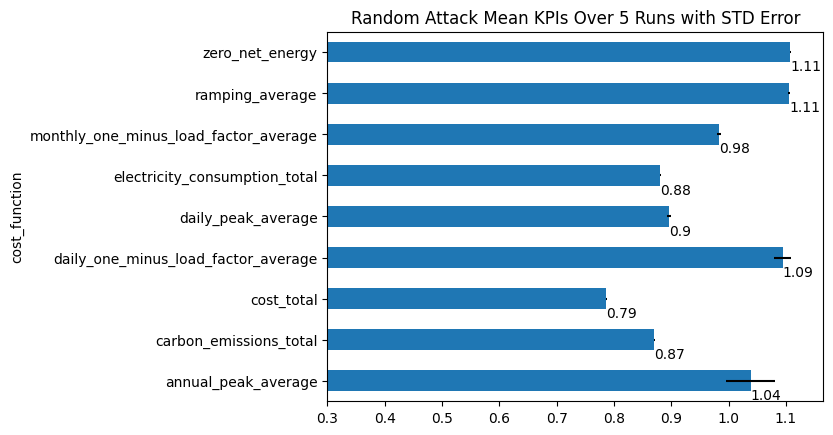

In [11]:
ax = df_kpis['mean'].plot.barh(xerr = df_kpis['std'], xlim=0.3, title='Random Attack Mean KPIs Over 5 Runs with STD Error')
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width(), 
            i.get_y()-0.2,
            str(round((i.get_width()), 2)), 
            fontsize=10, 
            #color='dimgrey'
            )

In [12]:
ASRs = [results[i][3] for i in range(len(results))]
print(f'For 5 runs of the random attack \nthe mean ASR is:{np.mean(ASRs):.3f}\nthe STD is: {np.std(ASRs):.3f}')

For 5 runs of the random attack 
the mean ASR is:0.129
the STD is: 0.004
